# Tutorial 3: Fully Convolutional Nets for Image Segmentation

## Downloading the data

In [ ]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brain2d-data.zip
! unzip brain2d-data.zip

## Setting data directory

In [1]:
# data directories
data_dir = '/vol/lab/course/416/data/mnist/' #DoC lab machines
data_brain_dir = '/vol/lab/course/416/data/brain2d/' #DoC lab machines
# data_dir = 'data/mnist/'
# data_brain_dir = 'data/brain2d/'

**Aims of this tutorial**:
- Introduce you to Fully Convolutional Networks.
- Showcase that fully connected/dense layers can be equally turned to convolutional.
- Show how Fully Convolutional Networks can be used for segmentation.

The tutorial contains material that you will need for the **coursework**.
You will implement a CNN using the nn.module of PyTorch.  

You will also get to see how CNNs can help segmenting brain tumours!  

**Prerequisites**:
- Familiar with Python and NumPy and PyTorch
- Familiar with logistic regression and MNIST
- Familiar with SGD, cross entropy


**Notes**:
- Docs for PyTorch's nn.Module you will use:  
https://pytorch.org/docs/stable/generated/torch.nn.Module.html
- Some helper functions are included below for loading and plotting data. They will be used out of the box below.

## Preliminaries: Loading and pre-processing MNIST (from Tutorial 3)
We will use MNIST as in previous tutorial. Below, we prepare the data for a CNN, *exactly* as in Tutorial 3.  
Make sure to refresh your memory about **shape of the data** involved.  

In [2]:
import numpy as np
import torchvision.datasets as dset


def get_mnist(data_dir, train):
    # data_dir: path to local directory where data is, or should be stored.
    # train: if True, return training data. If False, return test data.
    # download: if data not in data_dir, download it.
    data_set = dset.MNIST(root=data_dir, train=train, transform=None, download=True)
    # Students should only deal with numpy arrays, so that it's easy to follow.
    if train:
        data_x = np.asarray(data_set.data, dtype='uint8')
        data_y = np.asarray(data_set.targets, dtype='int16') # int64 by default
    else:
        data_x = np.asarray(data_set.data, dtype='uint8')
        data_y = np.asarray(data_set.targets, dtype='int16') # int64 by default
    return data_x, data_y


def make_lbls_onehot(lbls, num_classes):
    # lbls: np.array of shape [N]
    lbls_onehot = np.zeros(shape=(lbls.shape[0], num_classes ) )
    lbls_onehot[ np.arange(lbls_onehot.shape[0]), lbls ] = 1
    return lbls_onehot


# If datasets are not at specified location, they will be downloaded.
train_imgs, train_lbls = get_mnist(data_dir=data_dir, train=True)
test_imgs, test_lbls = get_mnist(data_dir=data_dir, train=False)

print("[train_imgs] Type: ", type(train_imgs), "|| Shape:", train_imgs.shape, "|| Data type: ", train_imgs.dtype )
print("[train_lbls] Type: ", type(train_lbls), "|| Shape:", train_lbls.shape, "|| Data type: ", train_lbls.dtype )
print('Class labels in train = ', np.unique(train_lbls))

print("[test_imgs] Type: ", type(test_imgs), "|| Shape:", test_imgs.shape, " || Data type: ", test_imgs.dtype )
print("[test_lbls] Type: ", type(test_lbls), "|| Shape:", test_lbls.shape, " || Data type: ", test_lbls.dtype )
print('Class labels in test = ', np.unique(test_lbls))

S_tr_samples = train_imgs.shape[0] # S hereafter. Number of training samples in database.
H_height = train_imgs.shape[1] # H hereafter
W_width = train_imgs.shape[2] # W hereafter
C_classes = len(np.unique(train_lbls)) # C hereafter

[train_imgs] Type:  <class 'numpy.ndarray'> || Shape: (60000, 28, 28) || Data type:  uint8
[train_lbls] Type:  <class 'numpy.ndarray'> || Shape: (60000,) || Data type:  int16
Class labels in train =  [0 1 2 3 4 5 6 7 8 9]
[test_imgs] Type:  <class 'numpy.ndarray'> || Shape: (10000, 28, 28)  || Data type:  uint8
[test_lbls] Type:  <class 'numpy.ndarray'> || Shape: (10000,)  || Data type:  int16
Class labels in test =  [0 1 2 3 4 5 6 7 8 9]


In [3]:
# Change representation of labels to one-hot vectors of length C=10. (Lec.5, sl.16)
train_lbls_onehot = np.zeros(shape=(train_lbls.shape[0], C_classes ) )
train_lbls_onehot[ np.arange(train_lbls_onehot.shape[0]), train_lbls ] = 1
test_lbls_onehot = np.zeros(shape=(test_lbls.shape[0], C_classes ) )
test_lbls_onehot[ np.arange(test_lbls_onehot.shape[0]), test_lbls ] = 1
print("BEFORE: [train_lbls]        Type: ", type(train_lbls), "|| Shape:", train_lbls.shape, " || Data type: ", train_lbls.dtype )
print("AFTER : [train_lbls_onehot] Type: ", type(train_lbls_onehot), "|| Shape:", train_lbls_onehot.shape, " || Data type: ", train_lbls_onehot.dtype )

BEFORE: [train_lbls]        Type:  <class 'numpy.ndarray'> || Shape: (60000,)  || Data type:  int16
AFTER : [train_lbls_onehot] Type:  <class 'numpy.ndarray'> || Shape: (60000, 10)  || Data type:  float64


In [4]:
# (Same as in Tut. 3)  
# Normalize intensities (from 0-255) to have 0-mean and 1-stdev. (Lec.5, sl.68)  
def normalize_int_whole_database(data):
    # data: shape [num_samples, H, W, C]
    mu = np.mean(data, axis=(0,1,2), keepdims=True) # Mean int of channel C, over samples and pixels.
    std = np.std(data, axis=(0,1,2), keepdims=True) # Returned shape: [1, 1, 1, C]
    norm_data = (data - mu) / std
    return norm_data

train_imgs = normalize_int_whole_database(train_imgs)
test_imgs = normalize_int_whole_database(test_imgs)

# Cross entropy for classifier (from Tutorial 3)

For better understanding, we use our own implementation. Of course, PyTorch has the cross entropy loss already implemented: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [5]:
def cross_entropy(y_pred, y_real, eps=1e-7):
    # y_pred: Tensor of shape [N, D_out]. Predicted class-posterior probabilities from forward.
    # y_real: Same shape as y_pred. One-hot representation of real labels.
    x_entr_per_sample = - torch.sum( y_real*torch.log(y_pred+eps), dim=1) # Sum over classes, axis=1
    loss = torch.mean(x_entr_per_sample, dim=0) # Expectation of loss: Mean over samples (axis=0).
    return loss

# Stochastic Gradient Descent (from Tutorial 3)

PyTorch has also very useful functionality for handling datasets and sampling of training data. However, to fully understand what's going, again, we make use of our own implementation here. More details about how PyTorch can help with handling data can be found here: https://pytorch.org/docs/stable/data.html

In [6]:
# Helpers
import matplotlib.pyplot as plt
%matplotlib inline

def plot_train_progress(loss_l, acc_train_l, acc_test_l, iters_per_point, total_iters=None):

    fig, axes = plt.subplots(1, 2, sharex=False, sharey=False)
    assert len(loss_l) == len(acc_train_l) == len(acc_test_l)
    x_points = range(0, len(loss_l)*iters_per_point, iters_per_point)
    
    axes[0].plot(x_points, loss_l, color="black", label="Training loss", linewidth=5)
    axes[0].set_title("Training loss", fontsize=10, y=1.022)
    axes[0].yaxis.grid(True, zorder=0)
    axes[0].set_xlabel('Iteration', fontsize=10)
    if total_iters is not None:
        axes[0].set_xlim([0,total_iters])
    axes[0].set_ylim([0,None])
    axes[0].legend(loc='upper right')
    
    axes[1].set_title("Accuracy", fontsize=10, y=1.022)
    axes[1].plot(x_points, acc_train_l, color="blue", label="Train", linewidth=5)
    axes[1].plot(x_points, acc_test_l, color="red", label="Test", linewidth=5)
    axes[1].yaxis.grid(True, zorder=0)
    axes[1].set_xlabel('Iteration', fontsize=10)
    if total_iters is not None:
        axes[1].set_xlim([0,total_iters])
    axes[1].set_ylim([0,100])
    axes[1].legend(loc='lower right')
    
    plt.show()
    

def plot_image(image, interpol="nearest", cmap="gray", vminmax=[None,None], figsize=None):
    # image: np.array of one of the following shapes:
    #       grayscale image:    (height, width)
    #       grayscale image:    (height, width, 1)
    #       rgb image:          (height, width, 3)
    print("Plotting image of shape: ", image.shape)
    plt.figure(figsize=figsize) # (figsize=(n_imgs_per_row*0.5, n_rows*0.5)) # size (width, height), in inches.
    if len(image.shape) == 2:
        fig = plt.imshow(image, cmap=cmap, interpolation=interpol, vmin=vminmax[0], vmax=vminmax[1]) # imshow: (w,h) or (w,h,3)
        plt.colorbar(fig)
    elif len(image.shape) == 3 and image.shape[2] == 1:
        fig = plt.imshow(image[:,:,0], cmap=cmap, interpolation=interpol, vmin=v_minmax[0], vmax=vminmax[1]) # imshow: (w,h) or (w,h,3)
        plt.colorbar(fig)
    elif len(image.shape) == 3 and image.shape[2] == 3 :
        _ = plt.imshow(image, interpolation=interpol)
    else:
        raise Error("Wrong shape of given image for plotting.")


def display_image_dynamically(image, interpol="nearest", cmap="gray", vminmax=[None,None], figsize=None):
    # image: np.array of one of the following shapes:
    #       grayscale image:    (height, width)
    #       grayscale image:    (height, width, 1)
    
    print("Plotting image of shape: ", image.shape)
    plt.figure(figsize=figsize) # (figsize=(n_imgs_per_row*0.5, n_rows*0.5)) # size (width, height), in inches.
    if len(image.shape) == 2:
        fig = plt.imshow(image, cmap=cmap, interpolation=interpol, vmin=vminmax[0], vmax=vminmax[1]) # imshow: (w,h) or (w,h,3)
        plt.colorbar(fig)
    elif len(image.shape) == 3 and image.shape[2] == 1:
        fig = plt.imshow(image[:,:,0], cmap=cmap, interpolation=interpol, vmin=v_minmax[0], vmax=vminmax[1]) # imshow: (w,h) or (w,h,3)
        plt.colorbar(fig)
    elif len(image.shape) == 3 and image.shape[2] == 3 :
        _ = plt.imshow(image, interpolation=interpol)
    else:
        raise Error("Wrong shape of given image for plotting.")
        
    #display.clear_output(wait=True)
    display.display(plt.gcf())

In [7]:
def compute_accuracy(lbls_pred, lbls_real):
    # lbls_pred, lbls_read: np.arrays of labels (after argmax), not probabilities/onehot.
    acc = np.mean(lbls_pred == lbls_real) * 100.
    return acc

def get_random_batch(train_imgs, train_lbls, N_batch_size, rng):
    # train_imgs: Images for training. Numpy array of shape [S, H, W]
    # train_lbls: Labels of the training images.
    # N_batch_size: integer. Size that the batch should have.
    indices = rng.randint(low=0, high=train_imgs.shape[0], size=N_batch_size, dtype='int32')
    train_imgs_batch = train_imgs[indices]
    train_lbls_batch = train_lbls[indices]
    return [train_imgs_batch, train_lbls_batch]

def gradient_descent(net, loss_func, grad_descent_optimizer, rng,
                     train_imgs, train_lbls, test_imgs, test_lbls,
                     N_batch_size, total_iters, iters_per_test=-1,
                     is_tumor_segm=False ):
    # net: Instance of a model.
    # loss_func: Function that computes the loss. See functions: cross_entropy.
    # grad_descent_optimizer: From torch.optim (see Task 2)
    # rng: numpy random number generator
    # train_imgs: The training images. Numpy array, shape [S_tr, H, W]
    # test_imgs: Save as above, for testing images. [S_te, H, W]
    # train_lbls: One hot representation of labels corresponding to train_imgs. Numpy array, shape [S_tr, C]
    # test_lbls: As above, but for testing data. [S_te, C]
    # N_batch_size: Size N of the batch that should be processed per SGD iteration by a model.
    # learning_rate: self explanatory.
    # total_iters: how many iterations in total to perform.
    # iters_per_test: Integer. Every that many iterations the model predicts the test data and accuracy is reported.
    values_to_plot = {'loss':[], 'acc_train': [], 'acc_test': []}
    
    for t in range(total_iters):
        
        x, y_real = get_random_batch(train_imgs, train_lbls, N_batch_size, rng)
        
        y_pred = net.forward( torch.tensor(x, dtype=torch.float) )
        
        loss = loss_func(y_pred, torch.tensor(y_real, dtype=torch.float)) # Cross Entropy

        loss.backward() # Computes grads with auto-differentiation. Stores them in each params.grads
        
        # Update weights with gradient descent. One of optimizers given by torch.optim
        grad_descent_optimizer.step()
        grad_descent_optimizer.zero_grad()  # zero the parameter gradients.
        
        # ==== Report training loss and accuracy ======
        lbls_pred = np.argmax(y_pred.detach().numpy(), axis=1) # Get labels from the probabilities.
        lbls_real = np.argmax(y_real, axis=1) # Get labels from one-hot
        acc_train = compute_accuracy(lbls_pred, lbls_real)
        print("[iter:", t, "]: Training Loss: {0:.2f}".format(loss.item()), "\t Accuracy: {0:.2f}".format(acc_train))
        
        # =============== Every few iterations, predict the testing-database ================#
        if t==total_iters-1 or t%iters_per_test == 0:
            y_pred_test = net.forward(torch.tensor(test_imgs, dtype=torch.float))
            y_pred_test_numpy = y_pred_test.detach().numpy()
            # ==== Report test accuracy ======
            lbls_pred_test = np.argmax(y_pred_test_numpy, axis=1)
            lbls_real_test = np.argmax(test_lbls, axis=1)
            acc_test = compute_accuracy(lbls_pred_test, lbls_real_test)
            print("\t\t\t\t\t\t\t\t Testing Accuracy: {0:.2f}".format(acc_test))
            
            # Keep list of metrics to plot progress.
            values_to_plot['loss'].append(loss.item())
            values_to_plot['acc_train'].append(acc_train)
            values_to_plot['acc_test'].append(acc_test)
            
            if is_tumor_segm:
                display_image_dynamically(y_pred_test_numpy[0,1,:,:])
                #scipy.misc.imsave('./pred_prob.png', y_pred_test_numpy[0,1,:,:])
                #scipy.misc.imsave('./pred_segm.png', lbls_pred_test[0,:,:])
                
                
    # In the end of the process, plot loss accuracy on training and testing data.
    plot_train_progress(values_to_plot['loss'], values_to_plot['acc_train'], values_to_plot['acc_test'], iters_per_test)

# Task 1: Build LeNet

In tutorial 3 we had built a tiny CNN, with just 1 convolution and 1 fully connected layer.  
Here, we will build the legendary LeNet.  

**Replicate** the code given to you in the lecture **CNNs for Image Segmentation** to build the architecture below:

We will build this by using the **nn** and **nn.Module** of PyTorch.

- **nn**: Helps developing nets easier by providing building blocks such as *layers*. For example, a **nn.Conv2d** layer internally initializes a weight kernel for its convolution operator, encapsulates a bias term, can apply padding to its input, etc. If we would do this using the basic operators given by *torch.nn.functional* (what we did in the last turorial), we have more transparency, but we got to do everything ourselves. Choose wisely.  
- **nn.Module**: A further abstraction module. This module should be used as a **parent class** for classes that represent whole networks. Then, Pytorch automatically keeps track of the net's parameters within **self.parameters**. All you need is to define the **forward** pass. This makes things clean as you will see...  

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Docs of nn.Conv2d and nn.Linear and max_pool2d:
# https://pytorch.org/docs/stable/_modules/torch/nn/modules/conv.html#Conv2d
# https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear
# https://pytorch.org/docs/stable/nn.html#torch.nn.functional.max_pool2d

class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        ######################### TODO: Build LeNet ########################
        # Make the above architecture of LeNet.
        # bias=True makes the layer create a bias internally. Nice and clean.
        # Conv2d gets args: (num input channs, num out channs, kernel_size ...)
        # Linear gets args: (num input neurons, num out neurons, ...)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, bias=True, padding=0) # Params are initialized internally.
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, bias=True, padding=0)
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=True) # nn.Linear is a fully connected layer.
        self.fc2 = nn.Linear(120, 84, bias=True)
        self.fc3 = nn.Linear(84, num_classes, bias=True)
        # All parameters of a nn.Module are afterwards accessible by self.parameters()
        # Each layer's weights and biases are accessible by eg by self.conv1.weight & self.conv1.bias
    
    def forward(self, x):
        # x: Input tensor (batch of images) of shape [N, Channels, H, W]
        # returns: tensor of shape [N, classes]. The class posterior probabilities.
        # Make the forward pass.
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0, ceil_mode=False)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0, ceil_mode=False)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        y_pred = F.softmax(x, dim=1) # y_pred.shape = [N, 10]
        ####################################################################
        return y_pred


# Task 2: Train LeNet classifier

train_imgs_cnn.shape should be (60000, 1, 32, 32). It is:  (60000, 1, 32, 32)
[iter: 0 ]: Training Loss: 2.29 	 Accuracy: 15.00
								 Testing Accuracy: 10.10
[iter: 1 ]: Training Loss: 2.31 	 Accuracy: 16.25
[iter: 2 ]: Training Loss: 2.30 	 Accuracy: 7.50
[iter: 3 ]: Training Loss: 2.31 	 Accuracy: 5.00
[iter: 4 ]: Training Loss: 2.30 	 Accuracy: 15.00
[iter: 5 ]: Training Loss: 2.31 	 Accuracy: 10.00
[iter: 6 ]: Training Loss: 2.30 	 Accuracy: 12.50
[iter: 7 ]: Training Loss: 2.30 	 Accuracy: 3.75
[iter: 8 ]: Training Loss: 2.30 	 Accuracy: 7.50
[iter: 9 ]: Training Loss: 2.30 	 Accuracy: 7.50
[iter: 10 ]: Training Loss: 2.31 	 Accuracy: 6.25
[iter: 11 ]: Training Loss: 2.29 	 Accuracy: 8.75
[iter: 12 ]: Training Loss: 2.29 	 Accuracy: 7.50
[iter: 13 ]: Training Loss: 2.29 	 Accuracy: 7.50
[iter: 14 ]: Training Loss: 2.29 	 Accuracy: 13.75
[iter: 15 ]: Training Loss: 2.29 	 Accuracy: 10.00
[iter: 16 ]: Training Loss: 2.29 	 Accuracy: 10.00
[iter: 17 ]: Training Loss: 2.30 	 Accura

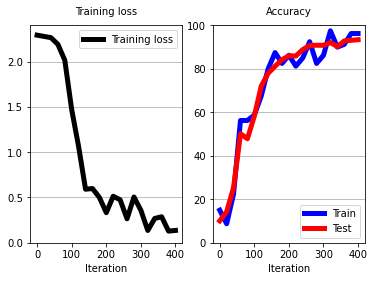

In [16]:
# (From Tutorial 3)
# Pytorch needs input to conv/pool to be of shape [N, Channels, H, W].
# For grayscale images, there is only 1 image channel. We add this *channels dimension*:
train_imgs_cnn = train_imgs.reshape([train_imgs.shape[0], 1, train_imgs.shape[1], train_imgs.shape[2]])
test_imgs_cnn = test_imgs.reshape([test_imgs.shape[0], 1, test_imgs.shape[1], test_imgs.shape[2]])

################ TODO: Pad images to fit to LeNet correctly ###################
# MNIST is 28x28 images. LeNet **by construction** requires images of shape 32x32 !
# with 2 voxels before and after H & W dimensions, to make them 32x32!
train_imgs_cnn = np.pad(train_imgs_cnn, ((0,0), (0,0), (2,2), (2,2)), mode='edge')
test_imgs_cnn = np.pad(test_imgs_cnn, ((0,0), (0,0), (2,2), (2,2)), mode='edge')
print("train_imgs_cnn.shape should be (60000, 1, 32, 32). It is: ", train_imgs_cnn.shape)
###############################################################################

# Create the network.
lenet = LeNet(num_classes=C_classes)

############## NOTE: Pytorch's optimizers (nothing to do here) #################
# Last time we wrote our own function for optimizing weights: w'=w-lr*grads.
# There are more complex ones (RMSProp, Adam, etc)
# Pytorch provides out-of-the-box optimizers that do this, so we dont need to write them.
# Create one, then call optimizer.step() & optimizer.zero_grad(). See SGD function above.
import torch.optim as optim
grad_descent_optimizer = optim.SGD(lenet.parameters(), lr=0.03, momentum=0.0)
################################################################################

# Start training
SEED = 42
rng = np.random.RandomState(seed=SEED) # Random number generator
gradient_descent(lenet,
                 cross_entropy,
                 grad_descent_optimizer,
                 rng,
                 train_imgs_cnn,
                 train_lbls_onehot,
                 test_imgs_cnn,
                 test_lbls_onehot,
                 N_batch_size=80,
                 total_iters=400,
                 iters_per_test=20,
                 is_tumor_segm=False)


If done correctly, accuracy should surpass 90% both on training and testing samples.  
You should see a pretty plot at the bottom of the output when process finishes.

# Task 3: Build Fully Convolutional LeNet

Fully convolutional networks are networks that do not have dense/fully-connected layers. Any network with dense layers has an **exactly equivalent** fully-convolutional architecture. A dense layer can be turned to a convolution with mathematically exact same behaviour. See lecture slides...

Explanation (check together with the slides):
- Assume **input X** to a dense layer is a matrix of shape **(num_in_channs, height, width)**, which is the output from a previous conv layer that has (num_inp_channs) **feature maps**, each of **dimensions** \[height, width\].  
- A dense layer with (num-out) neurons has **weight matrix W** of shape: \[num-out, num-in-channs * height * width\].  
- **Each of the output neurons** in a dense layer has (num_inp_channs * height_of_inp * width_of_inp) weights connecting it to the above input.  
- Out of these, there are (height*width) weights connecting each output neuron to each input feature map. Each of these weights is different.
- Thus the above (height*width) weights can be seen as a kernel of shape \[height, width\].
- The weights connecting each output neuron to all input feature maps can be seen as a convolutional kernel of shape \[1, num_in_channs, height, width\].
- The whole weight matrix W can be reorganized as a convolution kernel \[out_channs, num_in_channs, height, width\]
- The whole **dense layer with num-out-neurons** can be reorganized as a **convolutional layer with num-out feature-maps**, where **ach output feature-map gives only 1 activation** (is of height=1 and width=1). 
- The operation applied by a dense layer, **dot_product(X,W)**, can be now cast as a **convolution(X,W_reorganized)**, with the two being **mathematically equivallent**.  

(Note: Won't be needed here, but in some implementations of conv/cross-correlation, you would need to flip the kernel. Check difference between conv and cross-correlation.)

Below, we are going to build a Fully Convolutional LeNet, that corresponds exactly to the previous LeNet...

In [17]:
class FCLeNet(nn.Module):
    def __init__(self, num_classes):
        super(FCLeNet, self).__init__()
        ################ TODO: Build a Fully Convolutional LeNet ####################
        # Adjust LeNet's code, and replace all nn.Linear layers with appropriate nn.Conv2d
        # Conv2d gets args: (num input channs, num out channs, kernel_size ...)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, bias=True, padding=0)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, bias=True, padding=0)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, bias=True, padding=0)
        self.conv4 = nn.Conv2d(120, 84, kernel_size=1, bias=True, padding=0)
        self.conv5 = nn.Conv2d(84, num_classes, kernel_size=1, bias=True, padding=0)
        
    def forward(self, x):
        # x: Input tensor (batch of images) of shape [N, Channels, H, W]
        # returns: tensor of shape [N, classes] if input is of shape 32x32...
        # ... or Tensor of shape [N, classes, H_out, W_out if input >= 36x36.
        # Make the forward pass.
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0, ceil_mode=False)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0, ceil_mode=False)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        
        y_pred = F.softmax(x, dim=1) # y_pred.shape = [N, 10, 1, 1]
        #############################################################################
        
        # The output of LeNet was [N, 10] for input x of size 32x32.
        # y_pred here will be [N,10,1,1] if input x of size 32x32, ...
        # ... Or of shape [N, 10, H_out, W_out] if input larger than 32x32 is given.
        # If shape is [N,10,1,1], drop unary dimensions to have same behaviour as LeNet.
        if y_pred.shape[2] == 1 and y_pred.shape[3] == 1:
            y_pred = y_pred.reshape([y_pred.shape[0], y_pred.shape[1]])
            
        return y_pred

We above hopefully created a Fully Convolutional LeNet that we claimed can be mathematically equivalent to a LeNet with dense layers. Is it? Lets check...

Below, we will **transfer parameters** of the **pre-trained** LeNet (from Task 2) to FCLeNet, after we **reorganize them in convolutional kernels** of appropriate shape.

Then, we will apply both LeNet and FCLeNet, to check if we get the same result...

In [18]:
def transfer_weights_from_LeNet_to_FCLeNet(lenet, fclenet):
    # Docs on conv and linear layers, to see their .weight and .bias attributes:
    # https://pytorch.org/docs/stable/_modules/torch/nn/modules/conv.html#Conv2d
    # https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear

    
    ############# TODO: Complete the below #######################################
    # Match which layer of lenet should be transfered to which of FCLeNet.
    # Reshape the weights of dense layers of LeNet to the shape needed by the convs.
    
    # Shape of weights : conv [out channels, in channels, kh, kw] linear: [out ch, in ch]
    # Shape of biases: conv & linear have same shape: [out channels]
    # NOTE: Shape of conv.weight is switched in comparison to how declared in nn.Conv2d(...) above.
    # ... Here, [out_chans, in_chans, H, W]. Above at nn.Conv2d(in_chans, out_chans, H, W)
    fclenet.conv1.weight.data = lenet.conv1.weight.data.clone()
    fclenet.conv1.bias.data = lenet.conv1.bias.data.clone()
    fclenet.conv2.weight.data = lenet.conv2.weight.data.clone()
    fclenet.conv2.bias.data = lenet.conv2.bias.data.clone()
    fclenet.conv3.weight.data = lenet.fc1.weight.data.clone().reshape([120,16,5,5])
    fclenet.conv3.bias.data = lenet.fc1.bias.data.clone()
    fclenet.conv4.weight.data = lenet.fc2.weight.data.clone().reshape([84,120,1,1])
    fclenet.conv4.bias.data = lenet.fc2.bias.data.clone()
    fclenet.conv5.weight.data = lenet.fc3.weight.data.clone().reshape([-1,84,1,1])
    fclenet.conv5.bias.data = lenet.fc3.bias.data.clone()
    ##################################################################################
    
# Initialize an FCLeNet, and then transfer the weights from pre-trained LeNet to FCLeNet.
fclenet = FCLeNet(num_classes=C_classes)
transfer_weights_from_LeNet_to_FCLeNet(lenet, fclenet)

# Test with LeNet
y_pred_lenet = lenet.forward(torch.tensor(test_imgs_cnn, dtype=torch.float))
lbls_pred_lenet = np.argmax(y_pred_lenet.detach().numpy(), axis=1)
acc_lenet = compute_accuracy(lbls_pred_lenet, test_lbls)
# Test with FCLeNet
y_pred_fclenet = fclenet.forward(torch.tensor(test_imgs_cnn, dtype=torch.float))
lbls_pred_fclenet = np.argmax(y_pred_fclenet.detach().numpy(), axis=1)
acc_fclenet = compute_accuracy(lbls_pred_fclenet, test_lbls)

print("Accuracy of LeNet {0:.2f}".format(acc_lenet), " and FCLeNet {0:.2f}".format(acc_fclenet))


Accuracy of LeNet 93.41  and FCLeNet 93.41


If done correctly, you should get **exactly** the same result from LeNet and FCLeNet.  
It should also be the same as the final test-accuracy when training LeNet above.

# Task 4: Beyond classification with Fully Conv. Nets

If we convert a fully connected layer to a conv layer appropriately, we get the same output. What's useful about it then?

*As all operations are convolutional, the network can receive input larger than its receptive field.*  

LeNet had to receive 32x32 size of input by construction, and would return 1 output.
We say that it has a **receptive field** of size 32x32 by construction. *Size of receptive field* is how many pixels the net processes for its output neurons to give one output activation (prediction). The size of the receptive field is defined by the size of the kernels, their strides, and the numbers of layers.

FCLeNet has exactly the same size of receptive field with LeNet, since as we saw the two architectures are equivalent. It processes 32x32 pixels via convs and pools, and gives one output. But...  

... As whole FCLeNet is made of kernels convolving an output (pooling is the same), nothing stops it from receiving a larger input. If given an input larger than 32x32, kernels at each layer will be applied as normally, they will simply output more activations at the output feature maps. All feature maps will expand, *including the output feature maps*, that used to be 1x1 for 32x32 input, which will give more than one prediction.

Lets see this in practice...

Plotting image of shape:  (32, 32)
For input of shape: (1, 1, 32, 32)  FCLeNet gave output of shape  (1, 10)
Predicted class posterior probabilities: [[3.6822210e-05 1.1576886e-04 8.3441508e-04 7.3607938e-05 9.7981161e-01
  2.5271080e-04 4.2465833e-04 9.9902030e-04 3.8367245e-04 1.7067712e-02]]
Predicted class (argmax) is: [4]


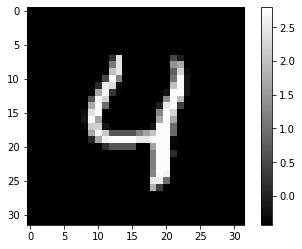

In [33]:
# Choose an index of an image to test on...
index_of_img = 4
image_for_cnn = test_imgs_cnn[ index_of_img : index_of_img+1, :, :, : ] # [1, 1, 32, 32]
real_lbl = test_lbls[index_of_img]
plot_image(image_for_cnn[0,0,:,:], cmap="gray")

######### TODO: Run inference on the ORIGINAL 32x32 image. ###################
# Do a forward pass with fclenet
pred_probs = fclenet.forward( torch.tensor(image_for_cnn, dtype=torch.float) ) # Outp shape: [1, 10]
pred_probs = pred_probs.detach().numpy() # make tensor numpy
pred_lbls = np.argmax(pred_probs, axis=1) # Shape: [1]
#############################################################################
print("For input of shape:", image_for_cnn.shape, " FCLeNet gave output of shape ", pred_probs.shape)
print("Predicted class posterior probabilities:", pred_probs)
print("Predicted class (argmax) is:", pred_lbls)


image_for_cnn_padded.shape : (1, 1, 64, 64)
Plotting image of shape:  (64, 64)


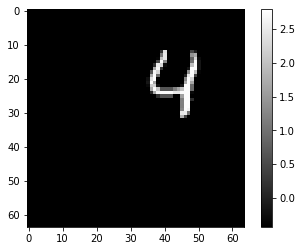

In [34]:
# Now make a larger image to apply FCLeNet on...
# Pad the 32x32 image in the H and W dimension enough to become 64 x 64
image_for_cnn_padded = np.pad(image_for_cnn, ((0,0),(0,0),(5,27),(27,5)), mode='edge')
print("image_for_cnn_padded.shape :", image_for_cnn_padded.shape)
plot_image(image_for_cnn_padded[0,0,:,:])

For input of shape: (1, 1, 64, 64)  FCLeNet gave output of shape: (1, 10, 9, 9)
Plotting output of Channel # 4 (real class) of the last conv layer (classification layer):
Plotting image of shape:  (9, 9)


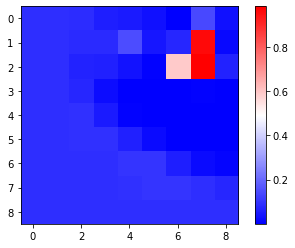

In [35]:
######### TODO: Run inference with FCLeNet on the padded 64 x 64 image.  ###############
pred_probs_padded = fclenet.forward( torch.tensor(image_for_cnn_padded, dtype=torch.float) ) # shape: [1, 10, H_out, W_out]
pred_probs_padded = pred_probs_padded.detach().numpy() # make tensor numpy
pred_lbls_padded = np.argmax(pred_probs_padded, axis=1) # Shape: [1, H_out, W_out]
########################################################################################
print("For input of shape:", image_for_cnn_padded.shape, " FCLeNet gave output of shape:", pred_probs_padded.shape)
print("Plotting output of Channel #", real_lbl, "(real class) of the last conv layer (classification layer):")
plot_image(pred_probs_padded[0,real_lbl,:,:], cmap="bwr")

For a 64 x 64 input, FCLeNet.forward() should output a \[1,10,9,9\] matrix. For each of the 10 classes, it outputs a *probability map* of size \[9,9\] (the feature map output by the last conv). Above you should see plotted the probability map for the *real* class of the digit in the input.

**Q: Why 9x9 pixels in the output? (It has to do with the strides of the pooling layers and the size of input.)**  
**A: In the lecture slides...**

# Task 5: Upsample the output to the original resolution

Comparing the output with the padded 64x64 image, it looks as if the network **localizes** the digit in the image. But the output is in low resolution. Why? Because of the x4 downsampling done inside the network by the 2 pooling layers (each downsamples x2).

Lets **upsample** it back to original resolution with **interpolation**. We will do this following the method discussed in the lecture slides.
- **Repeat elements x4** in the spatial dimensions (H,W).  
- Then **convolve with a uniform kernel** in the spatial dimensions (H,W).

Plotting image after repetition....................
Plotting image of shape:  (36, 36)
Upsampled image after repetition has shape: (1, 10, 36, 36)
Plotting image after convolution...................
Plotting image of shape:  (33, 33)
Upsampled image after convolution has shape: (1, 10, 33, 33)


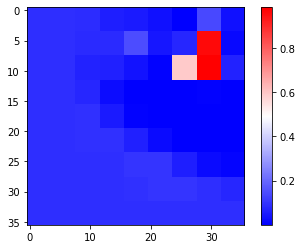

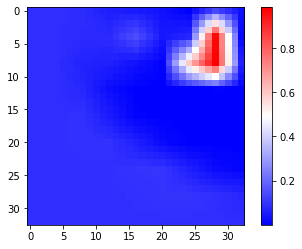

In [53]:
from scipy import signal

############# TODO: Repeat elements x4 along the two spatial dimensions #####################
pred_probs_padded_ups = np.repeat(pred_probs_padded, repeats=4, axis=2) # [N,Class,H,W]
pred_probs_padded_ups = np.repeat(pred_probs_padded_ups, repeats=4, axis=3)
print("Plotting image after repetition....................")
plot_image(pred_probs_padded_ups[0,real_lbl,:,:], cmap="bwr")
print("Upsampled image after repetition has shape:", pred_probs_padded_ups.shape) # (1, 10, 36, 36)
############################################################################################
# Convolve with uniform kernel:
kernel = np.ones([1,1,4,4])/16.
pred_probs_padded_ups = signal.convolve(pred_probs_padded_ups, kernel, mode='valid')
print("Plotting image after convolution...................")
plot_image(pred_probs_padded_ups[0,4], cmap="bwr")

print("Upsampled image after convolution has shape:", pred_probs_padded_ups.shape) # (1, 10, 33, 33)

If done right, you will notice it looks like a very good localisation of the digit.

Notice the shape of the upsampled image. It should be 33x33.  
- The initial 9x9 voxels were repeated x4, up to 36x36.  
- The convolution with mode='valid' requires that the kernel is fully contained in the image for a response.  
- Thus, convolving a 36x36 image with a 4x4 kernel gives 33x33 responses.  
- The whole process can be seen as if we interpolated 3 voxels in between each of the original 9x9 voxels.

*Each 'valid' convolution with kernel of size k reduces the shape of the input by k-1.*  
**Why do we care?** Because this is what happens within the neural network as well with every conv/pool.  

**Eventhough we upsampled, the output is not same size as the original input, 64x64. Why?**  
Exactly because of the above behaviour of the **'valid' convolutions within the net (and pools with ceiling=True)**.  
With every conv or pool with kernel of size k, the feature maps get reduced in size by (k-1). **Except** if we use **padding=True** in the net, though this may cause problems for segmentation (cf. lecture slides).  
Padding was quite irrelevant for classification nets, but becomes important for segmentation.

**Q: The output (33x33) is 31 pixels smaller in each spatial dimension in comparison to the input (64x64). Can you come up with an equation that computes how much is the output's size, as a function of the input's size and the size of the receptive field of the network?**  
**A: ???**

Note: Very good material is in Theano's documentation (discontinued, original DL library): https://theano-pymc.readthedocs.io/en/latest/tutorial/conv_arithmetic.html



# Task 6: Segmentation of Brain Tumors with FCLeNet

Recap of what we have seen:
- Fully convolutional nets can be used to **localise** something in an image.
- Their **output** is of **lower resolution** due to conv/pool with *strides*.
- **Output is smaller** than the input image, shrinking around the borders with every **'valid' conv/pool**.

In this last, most important task, we will combine all we have learned:
- We will use FCLeNet for **segmentation** of an image.
- We will extend FCLeNet for segmentation, to **learn to upsample within the net**.
- We will ensure to segment the whole image, by **padding the input** as required.

For this, we will use a new database. We will segment brain tumors, from 2D slices of brain MRIs.  

**Note: This is related to the task you will get for the coursework, so invest time to understand it.**


### Preliminary: Load data & make one-hot ground truth labels

The below will load brain images and segmentation labels for training and testing.  
It is exactly the same as the steps we were taking for MNIST, except that we don't normalize intentisities. **They are already loaded normalized**.  

The only **important difference** are the ground truth labels for segmentation...

[train_imgs] Type:  <class 'numpy.ndarray'> || Shape: (2, 169, 129) || Data type:  float64
[train_lbls] Type:  <class 'numpy.ndarray'> || Shape: (2, 169, 129) || Data type:  uint8
[train] Intensities in images [min,max]: -1.6122578242528567 4.101347108239887
[train] Values in class labels: [0 1]
[test_imgs] Type:  <class 'imageio.core.util.Array'> || Shape: (1, 169, 129) || Data type:  float64
[test_lbls] Type:  <class 'imageio.core.util.Array'> || Shape: (1, 169, 129) || Data type:  uint8
[test] Intensities in images [min,max]: -1.3070482203383063 3.7549178309060265
[test] Values in class labels: [0 1]
[train_lbls]        Type:  <class 'numpy.ndarray'> || Shape: (2, 169, 129)  || Data type:  uint8
[train_lbls_onehot] Type:  <class 'numpy.ndarray'> || Shape: (2, 2, 169, 129)  || Data type:  float64
[test_lbls]        Type:  <class 'imageio.core.util.Array'> || Shape: (1, 169, 129)  || Data type:  uint8
[test_lbls_onehot] Type:  <class 'numpy.ndarray'> || Shape: (1, 2, 169, 129)  || Dat

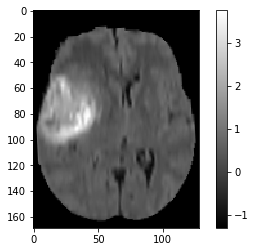

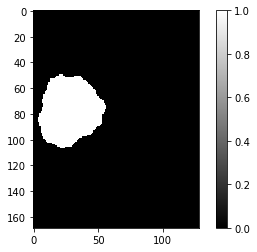

In [55]:
import numpy as np
import imageio


def get_tumor_data(data_dir, train):
    if train:
        paths_to_imgs =[data_dir + "image_0.png",
                        data_dir + "image_1.png"]
        paths_to_gts = [data_dir + "seg_0.png",
                        data_dir + "seg_1.png"]
    else: # test
        paths_to_imgs =[data_dir + "image_2.png"]
        paths_to_gts = [data_dir + "seg_2.png"]

    assert len(paths_to_imgs) == len(paths_to_gts)
    data_x = None
    data_y = None
    for i in range(len(paths_to_imgs)):
        img = imageio.imread(paths_to_imgs[i]) # [H, W]
        img = np.reshape(img, newshape=[1]+list(img.shape)) # [1, H, W]
        gt  = imageio.imread(paths_to_gts[i]) # [H, W]
        gt  = np.reshape(gt, newshape=[1]+list(gt.shape)) # [1, H, W]
        if data_x is None:
            data_x = img.copy()
            data_y = gt.copy()
        else:
            data_x = np.concatenate((data_x, img), axis=0) # [N, H, W]
            data_y = np.concatenate((data_y, gt), axis=0) # [N, H, W]
            
    data_x = (data_x - np.mean(data_x, axis=(1,2), keepdims=True))/np.std(data_x, axis=(1,2), keepdims=True)
    data_y[data_y>0] = 1
    return data_x, data_y


# Load the data. NOTE: Their intensities are already normalized.
train_imgs, train_lbls = get_tumor_data(data_dir=data_brain_dir, train=True)
test_imgs, test_lbls = get_tumor_data(data_dir=data_brain_dir, train=False)

print("[train_imgs] Type: ", type(train_imgs), "|| Shape:", train_imgs.shape, "|| Data type: ", train_imgs.dtype )
print("[train_lbls] Type: ", type(train_lbls), "|| Shape:", train_lbls.shape, "|| Data type: ", train_lbls.dtype )
print('[train] Intensities in images [min,max]:', np.min(train_imgs), np.max(train_imgs))
print('[train] Values in class labels:', np.unique(train_lbls))
print("[test_imgs] Type: ", type(test_imgs), "|| Shape:", test_imgs.shape, "|| Data type: ", test_imgs.dtype )
print("[test_lbls] Type: ", type(test_lbls), "|| Shape:", test_lbls.shape, "|| Data type: ", test_lbls.dtype )
print('[test] Intensities in images [min,max]:', np.min(test_imgs), np.max(test_imgs))
print('[test] Values in class labels:', np.unique(test_lbls))

C_classes = len(np.unique(train_lbls))

# Change representation of labels to one-hot vectors of length C=2.
def make_NHW_lbls_onehot(lbls, num_classes):
    # lbls: np.array [N, H, W], ints
    # returns: np.array [N, H, W, C], 0 or 1
    onehot_shape = (lbls.shape[0], num_classes, lbls.shape[1], lbls.shape[2])
    lbls_onehot = np.zeros(shape=onehot_shape)
    for n in range(lbls.shape[0]):
        for x in range(lbls.shape[1]):
            for y in range(lbls.shape[2]):
                for c in range(num_classes):
                    lbls_onehot[n,c,x,y] = 1 if lbls[n,x,y] == c else 0
    return lbls_onehot

train_lbls_onehot = make_NHW_lbls_onehot(train_lbls, C_classes)
test_lbls_onehot = make_NHW_lbls_onehot(test_lbls, C_classes)
print("[train_lbls]        Type: ", type(train_lbls), "|| Shape:", train_lbls.shape, " || Data type: ", train_lbls.dtype )
print("[train_lbls_onehot] Type: ", type(train_lbls_onehot), "|| Shape:", train_lbls_onehot.shape, " || Data type: ", train_lbls_onehot.dtype )
print("[test_lbls]        Type: ", type(test_lbls), "|| Shape:", test_lbls.shape, " || Data type: ", test_lbls.dtype )
print("[test_lbls_onehot] Type: ", type(test_lbls_onehot), "|| Shape:", test_lbls_onehot.shape, " || Data type: ", test_lbls_onehot.dtype )

# Plot the test image...
print("Plotting the test image and its ground truth segmentation label.")
plot_image(test_imgs[0,:,:])
plot_image(test_lbls[0,:,:])


Observe in the output of the above:
- We have 2 training images, each of shape 169 x 129. (train_imgs.shape = (2, 169, 129))  
- We have 1 testing image, also of shape 169 x 129. (test_imgs.shape = (1, 169, 129))  

Each has an associated ground truth **segmentation mask**:
- Each segmentation mask is also of shape 169 x 129. **Aligned** with corresponding image.
- Each segmentation mask is **binary**. A pixel has value 0 if it is **backround**, 1 if it is **tumor**.
- We have 2 segmentation masks for training (train_lbls.shape=(2,169,129))
- We have 1 segmentation mask for testing (test_lbls.shape=(2,169,129))
- The one-hot segmentation masks are respectively of shape (2, 2, 169, 129) and (1, 2, 169, 129).

For example:  
train_lbls_onehot\[0,1,50,60\]==1 if in the 1st training image, the pixel at position \[50,60\] is a tumor.

**The segmentation masks can be perceived as if they provide classification labels per pixel.**  
Subsequently, we are going to train a **CNN for segmentation**.  
It can be perceived as if we train it to do **pixel-wise classification**...

# Build FCLeNet with learnt upsampling for segmentation

For segmentation, we need fully-convolutional networks, but with output that is at the same resolution as their input. So that they give us a predicted class posterior probability for each pixel.

Below, we will extend FCLeNet by performing upsampling 4x within the network.  
This is to reverse the 2x downsampling made by the 2 pooling layers.  
We will do this similarly to how we upsampled the output of FCLeNet in task 6:  
- Repeat by 4x in each spatial dimension the feature maps of the last hidden layer.
- Convolve with a kernel of \[height,width\]=\[4,4\]
- We are going to *learn* the kernel for the convolution of the upsampling module, instead for a fixed one.

**Note: The above procedure is similar to what transpose-convolution internally implements (often called deconvolution in DL literature).**

In [56]:
# Helper function
def torch_repeat(in_tens, repeats, axis):
    # Repeat FM in the 2 last dimensions, to upsample back to the normal resolution space.
    # in_tens: [batch size, num of FMs, H, W]. Input/output of conv layers.
    # repeat_per_dim: [repetitions axis H, repetitions axis W]
    # returns: Tensor of size: [batch size, num of FMs, H*repeat[0], W*repeat[1] ]
    
    # NOTE: Exactly the same API and behaviour as numpy.repeat(...)
    # Because torch.repeat is similar to numpy.tile(...), not what we want.
    # See: https://stackoverflow.com/questions/35227224/torch-repeat-tensor-like-numpy-repeat
    tens = in_tens
    assert axis>0
    # Combine dimension to previous
    shape_flat = list(in_tens.shape)
    shape_flat[axis-1] = in_tens.shape[axis-1]*in_tens.shape[axis]
    shape_flat[axis] = 1
    tens_flat = tens.reshape( shape_flat )
    # Tile
    repeat_per_dim = [1]*len(in_tens.shape)
    repeat_per_dim[axis] = repeats
    tens_rep_flat = tens_flat.repeat( repeat_per_dim ) # This is what numpy.tile(...) does.
    # Reshape to what it should be.
    shape_result = list(in_tens.shape)
    shape_result[axis] = in_tens.shape[axis]*repeats
    tens_rep = tens_rep_flat.reshape( shape_result )
    return tens_rep

In [57]:
class FCLeNet_Seg(nn.Module):
    def __init__(self, num_classes):
        super(FCLeNet_Seg, self).__init__()
        ############## TODO: Complete the implementation ##################################
        # Create exactly the same implementation as FCLeNet, but with one added layer:
        # conv(5x5)->pool(2x2)->conv(5x5)->pool(2x2)->conv(5x5)->conv(1x1)->upsample->conv(1x1)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, bias=True, padding=0)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, bias=True, padding=0)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, bias=True, padding=0)
        self.conv4 = nn.Conv2d(120, 84, kernel_size=1, bias=True, padding=0)
        self.conv_ups = nn.Conv2d(84, 84, kernel_size=4, bias=False, padding=0) # Kernel for the upsampling step.
        self.conv5 = nn.Conv2d(84, num_classes, kernel_size=1, bias=True, padding=0)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0, ceil_mode=False)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0, ceil_mode=False)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch_repeat(x, repeats=4, axis=2) # Repeat 1 of upsampling step, ala Task 6.
        x = torch_repeat(x, repeats=4, axis=3) # Repeat 2 of upsampling step, ala Task 6.
        x = self.conv_ups(x) 
        x = self.conv5(x)
        # Note: The repeats and conv_ups can be replaced with a single torch.nn.ConvTranspose2d ...
        # ... but we prefer looking under the hood.
        ###################################################################################
        
        y_pred = F.softmax(x, dim=1) # y_pred.shape = [N, Classes, H_out, W_out]
        return y_pred
    

### Cross entropy for segmentation

We below provide the cross-entropy loss that will be used in the case of segmentation.   
It is *almost* the same as the one used for classification (preliminaries of this tutorial and Tutorial 3).  

As we previously mentioned, a segmentation network can be seen as if it is trained for pixel-wise classification.  
As such, it can be perceived as if **in the loss, each pixel is treated as another sample**.  
Thus the final torch.mean(...) is taken over the batch samples (images N) and each of the H_out*W_out pixels.  
Compare with classification cross entropy for clarity (beginning of tutorial).


In [59]:
def cross_entropy_segmentation(y_pred, y_real, eps=1e-7):
    # Cross entropy for segmentation.
    # y_pred: Tensor of shape [N, Classes, H_out, W_out]. Predicted class-posterior probabilities from forward().
    # y_real: One-hot representation of segmentation masks. Same shape as y_pred.
    
    x_entr_per_sample = - torch.sum( y_real * torch.log(y_pred + eps), dim=1) # Sum over classes.
    # x_entr_per_sample is now of shape [N, H_out, W_out]
    loss = torch.mean(x_entr_per_sample, dim=(0,1,2)) # Mean over batch & over spatial positions.
    
    return loss

# Train FCLeNet for segmentation

Finally, we will train the network.

But don't forget. Our network's outputs are 31 pixels less in each spatial dimension (H,W) than the input.  
So, to get a segmentation for the whole input, we will first **pad input with 31 pixels along dimensions (H,W)**.

train_imgs_cnn.shape= (2, 1, 200, 160)
train_lbls.shape= (2, 169, 129)
[iter: 0 ]: Training Loss: 0.62 	 Accuracy: 92.81
								 Testing Accuracy: 90.18
Plotting image of shape:  (169, 129)


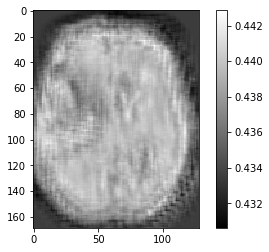

[iter: 1 ]: Training Loss: 0.60 	 Accuracy: 89.87
[iter: 2 ]: Training Loss: 0.57 	 Accuracy: 92.81
[iter: 3 ]: Training Loss: 0.56 	 Accuracy: 89.87
[iter: 4 ]: Training Loss: 0.53 	 Accuracy: 92.81
[iter: 5 ]: Training Loss: 0.53 	 Accuracy: 89.87
[iter: 6 ]: Training Loss: 0.51 	 Accuracy: 89.87
[iter: 7 ]: Training Loss: 0.47 	 Accuracy: 92.81
[iter: 8 ]: Training Loss: 0.43 	 Accuracy: 95.75
[iter: 9 ]: Training Loss: 0.42 	 Accuracy: 92.81
[iter: 10 ]: Training Loss: 0.40 	 Accuracy: 92.81
								 Testing Accuracy: 90.18
Plotting image of shape:  (169, 129)


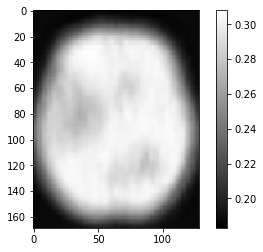

[iter: 11 ]: Training Loss: 0.34 	 Accuracy: 95.75
[iter: 12 ]: Training Loss: 0.30 	 Accuracy: 95.75
[iter: 13 ]: Training Loss: 0.26 	 Accuracy: 95.75
[iter: 14 ]: Training Loss: 0.23 	 Accuracy: 95.75
[iter: 15 ]: Training Loss: 0.33 	 Accuracy: 89.87
[iter: 16 ]: Training Loss: 0.21 	 Accuracy: 95.75
[iter: 17 ]: Training Loss: 0.24 	 Accuracy: 92.81
[iter: 18 ]: Training Loss: 0.23 	 Accuracy: 92.81
[iter: 19 ]: Training Loss: 0.27 	 Accuracy: 89.87
[iter: 20 ]: Training Loss: 0.26 	 Accuracy: 89.87
								 Testing Accuracy: 90.18
Plotting image of shape:  (169, 129)


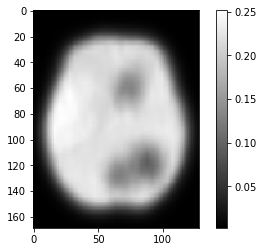

[iter: 21 ]: Training Loss: 0.17 	 Accuracy: 95.75
[iter: 22 ]: Training Loss: 0.16 	 Accuracy: 95.75
[iter: 23 ]: Training Loss: 0.20 	 Accuracy: 92.81
[iter: 24 ]: Training Loss: 0.15 	 Accuracy: 95.75
[iter: 25 ]: Training Loss: 0.19 	 Accuracy: 92.81
[iter: 26 ]: Training Loss: 0.18 	 Accuracy: 92.81
[iter: 27 ]: Training Loss: 0.18 	 Accuracy: 92.81
[iter: 28 ]: Training Loss: 0.17 	 Accuracy: 92.81
[iter: 29 ]: Training Loss: 0.21 	 Accuracy: 89.87
[iter: 30 ]: Training Loss: 0.21 	 Accuracy: 89.87
								 Testing Accuracy: 90.18
Plotting image of shape:  (169, 129)


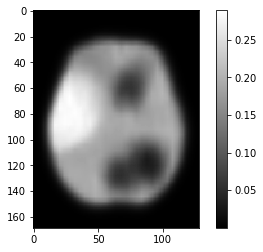

[iter: 31 ]: Training Loss: 0.20 	 Accuracy: 89.87
[iter: 32 ]: Training Loss: 0.16 	 Accuracy: 92.81
[iter: 33 ]: Training Loss: 0.16 	 Accuracy: 92.81
[iter: 34 ]: Training Loss: 0.11 	 Accuracy: 95.75
[iter: 35 ]: Training Loss: 0.11 	 Accuracy: 95.75
[iter: 36 ]: Training Loss: 0.15 	 Accuracy: 92.81
[iter: 37 ]: Training Loss: 0.15 	 Accuracy: 92.81
[iter: 38 ]: Training Loss: 0.10 	 Accuracy: 95.75
[iter: 39 ]: Training Loss: 0.15 	 Accuracy: 92.81
[iter: 40 ]: Training Loss: 0.14 	 Accuracy: 92.81
								 Testing Accuracy: 90.18
Plotting image of shape:  (169, 129)


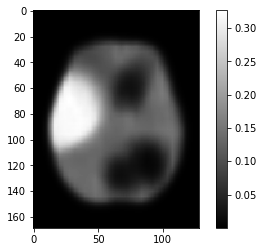

[iter: 41 ]: Training Loss: 0.14 	 Accuracy: 92.81
[iter: 42 ]: Training Loss: 0.17 	 Accuracy: 89.87
[iter: 43 ]: Training Loss: 0.13 	 Accuracy: 92.81
[iter: 44 ]: Training Loss: 0.09 	 Accuracy: 95.75
[iter: 45 ]: Training Loss: 0.09 	 Accuracy: 95.75
[iter: 46 ]: Training Loss: 0.09 	 Accuracy: 95.75
[iter: 47 ]: Training Loss: 0.08 	 Accuracy: 95.75
[iter: 48 ]: Training Loss: 0.08 	 Accuracy: 95.75
[iter: 49 ]: Training Loss: 0.13 	 Accuracy: 92.81
[iter: 50 ]: Training Loss: 0.12 	 Accuracy: 92.81
								 Testing Accuracy: 90.18
Plotting image of shape:  (169, 129)


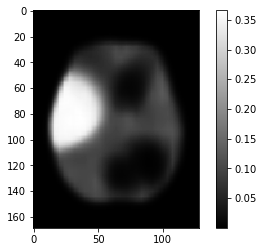

[iter: 51 ]: Training Loss: 0.08 	 Accuracy: 95.75
[iter: 52 ]: Training Loss: 0.08 	 Accuracy: 95.75
[iter: 53 ]: Training Loss: 0.08 	 Accuracy: 95.75
[iter: 54 ]: Training Loss: 0.12 	 Accuracy: 92.81
[iter: 55 ]: Training Loss: 0.12 	 Accuracy: 92.81
[iter: 56 ]: Training Loss: 0.07 	 Accuracy: 95.75
[iter: 57 ]: Training Loss: 0.12 	 Accuracy: 92.81
[iter: 58 ]: Training Loss: 0.11 	 Accuracy: 92.81
[iter: 59 ]: Training Loss: 0.11 	 Accuracy: 92.81
[iter: 60 ]: Training Loss: 0.11 	 Accuracy: 92.81
								 Testing Accuracy: 90.18
Plotting image of shape:  (169, 129)


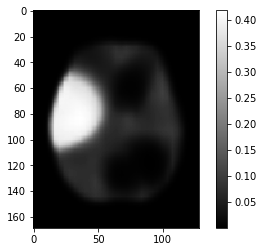

[iter: 61 ]: Training Loss: 0.10 	 Accuracy: 92.81
[iter: 62 ]: Training Loss: 0.10 	 Accuracy: 92.81
[iter: 63 ]: Training Loss: 0.10 	 Accuracy: 92.81
[iter: 64 ]: Training Loss: 0.07 	 Accuracy: 95.75
[iter: 65 ]: Training Loss: 0.11 	 Accuracy: 92.81
[iter: 66 ]: Training Loss: 0.13 	 Accuracy: 89.87
[iter: 67 ]: Training Loss: 0.12 	 Accuracy: 89.99
[iter: 68 ]: Training Loss: 0.11 	 Accuracy: 91.99
[iter: 69 ]: Training Loss: 0.11 	 Accuracy: 93.91
[iter: 70 ]: Training Loss: 0.09 	 Accuracy: 96.69
								 Testing Accuracy: 94.33
Plotting image of shape:  (169, 129)


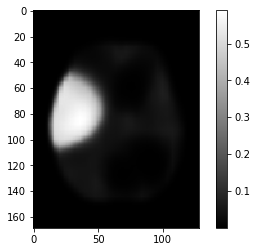

[iter: 71 ]: Training Loss: 0.05 	 Accuracy: 97.00
[iter: 72 ]: Training Loss: 0.09 	 Accuracy: 95.12
[iter: 73 ]: Training Loss: 0.10 	 Accuracy: 97.56
[iter: 74 ]: Training Loss: 0.09 	 Accuracy: 98.37
[iter: 75 ]: Training Loss: 0.10 	 Accuracy: 96.33
[iter: 76 ]: Training Loss: 0.08 	 Accuracy: 97.81
[iter: 77 ]: Training Loss: 0.08 	 Accuracy: 98.18
[iter: 78 ]: Training Loss: 0.07 	 Accuracy: 97.50
[iter: 79 ]: Training Loss: 0.07 	 Accuracy: 98.22
[iter: 80 ]: Training Loss: 0.09 	 Accuracy: 96.82
								 Testing Accuracy: 96.84
Plotting image of shape:  (169, 129)


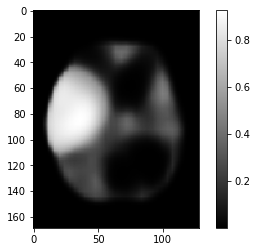

[iter: 81 ]: Training Loss: 0.14 	 Accuracy: 95.07
[iter: 82 ]: Training Loss: 0.29 	 Accuracy: 92.81
[iter: 83 ]: Training Loss: 0.26 	 Accuracy: 80.34
[iter: 84 ]: Training Loss: 0.17 	 Accuracy: 95.05
[iter: 85 ]: Training Loss: 0.15 	 Accuracy: 97.76
[iter: 86 ]: Training Loss: 0.14 	 Accuracy: 98.21
[iter: 87 ]: Training Loss: 0.13 	 Accuracy: 98.82
[iter: 88 ]: Training Loss: 0.13 	 Accuracy: 96.01
[iter: 89 ]: Training Loss: 0.12 	 Accuracy: 96.95
[iter: 90 ]: Training Loss: 0.11 	 Accuracy: 97.50
								 Testing Accuracy: 96.95
Plotting image of shape:  (169, 129)


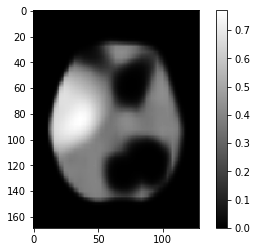

[iter: 91 ]: Training Loss: 0.12 	 Accuracy: 98.25
[iter: 92 ]: Training Loss: 0.11 	 Accuracy: 97.43
[iter: 93 ]: Training Loss: 0.11 	 Accuracy: 98.24
[iter: 94 ]: Training Loss: 0.10 	 Accuracy: 98.20
[iter: 95 ]: Training Loss: 0.10 	 Accuracy: 97.16
[iter: 96 ]: Training Loss: 0.09 	 Accuracy: 97.62
[iter: 97 ]: Training Loss: 0.10 	 Accuracy: 98.11
[iter: 98 ]: Training Loss: 0.09 	 Accuracy: 98.98
[iter: 99 ]: Training Loss: 0.11 	 Accuracy: 96.35
[iter: 100 ]: Training Loss: 0.09 	 Accuracy: 98.20
								 Testing Accuracy: 96.97
Plotting image of shape:  (169, 129)


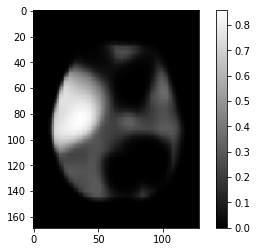

[iter: 101 ]: Training Loss: 0.09 	 Accuracy: 97.22
[iter: 102 ]: Training Loss: 0.09 	 Accuracy: 98.13
[iter: 103 ]: Training Loss: 0.07 	 Accuracy: 99.00
[iter: 104 ]: Training Loss: 0.08 	 Accuracy: 97.54
[iter: 105 ]: Training Loss: 0.09 	 Accuracy: 97.05
[iter: 106 ]: Training Loss: 0.07 	 Accuracy: 97.57
[iter: 107 ]: Training Loss: 0.07 	 Accuracy: 97.67
[iter: 108 ]: Training Loss: 0.08 	 Accuracy: 97.86
[iter: 109 ]: Training Loss: 0.06 	 Accuracy: 98.24
[iter: 110 ]: Training Loss: 0.07 	 Accuracy: 97.38
								 Testing Accuracy: 96.94
Plotting image of shape:  (169, 129)


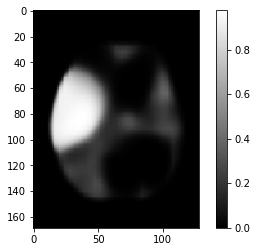

[iter: 111 ]: Training Loss: 0.08 	 Accuracy: 98.38
[iter: 112 ]: Training Loss: 0.04 	 Accuracy: 98.45
[iter: 113 ]: Training Loss: 0.06 	 Accuracy: 98.08
[iter: 114 ]: Training Loss: 0.06 	 Accuracy: 97.56
[iter: 115 ]: Training Loss: 0.07 	 Accuracy: 98.35
[iter: 116 ]: Training Loss: 0.04 	 Accuracy: 98.39
[iter: 117 ]: Training Loss: 0.04 	 Accuracy: 99.09
[iter: 118 ]: Training Loss: 0.03 	 Accuracy: 98.86
[iter: 119 ]: Training Loss: 0.06 	 Accuracy: 98.13
[iter: 120 ]: Training Loss: 0.05 	 Accuracy: 98.26
								 Testing Accuracy: 97.04
Plotting image of shape:  (169, 129)


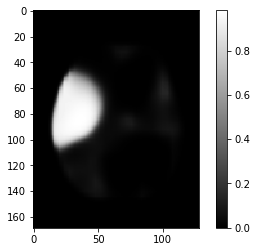

[iter: 121 ]: Training Loss: 0.05 	 Accuracy: 98.27
[iter: 122 ]: Training Loss: 0.05 	 Accuracy: 98.30
[iter: 123 ]: Training Loss: 0.06 	 Accuracy: 97.62
[iter: 124 ]: Training Loss: 0.05 	 Accuracy: 97.94
[iter: 125 ]: Training Loss: 0.05 	 Accuracy: 98.18
[iter: 126 ]: Training Loss: 0.05 	 Accuracy: 98.34
[iter: 127 ]: Training Loss: 0.05 	 Accuracy: 97.89
[iter: 128 ]: Training Loss: 0.05 	 Accuracy: 98.15
[iter: 129 ]: Training Loss: 0.05 	 Accuracy: 98.33
[iter: 130 ]: Training Loss: 0.04 	 Accuracy: 98.38
								 Testing Accuracy: 96.97
Plotting image of shape:  (169, 129)


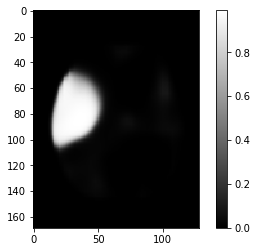

[iter: 131 ]: Training Loss: 0.06 	 Accuracy: 97.76
[iter: 132 ]: Training Loss: 0.06 	 Accuracy: 97.90
[iter: 133 ]: Training Loss: 0.03 	 Accuracy: 99.10
[iter: 134 ]: Training Loss: 0.07 	 Accuracy: 97.42
[iter: 135 ]: Training Loss: 0.10 	 Accuracy: 96.36
[iter: 136 ]: Training Loss: 0.06 	 Accuracy: 96.75
[iter: 137 ]: Training Loss: 0.05 	 Accuracy: 98.24
[iter: 138 ]: Training Loss: 0.04 	 Accuracy: 98.48
[iter: 139 ]: Training Loss: 0.04 	 Accuracy: 98.52
[iter: 140 ]: Training Loss: 0.03 	 Accuracy: 99.00
								 Testing Accuracy: 96.56
Plotting image of shape:  (169, 129)


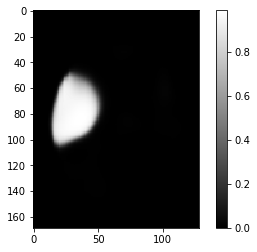

[iter: 141 ]: Training Loss: 0.04 	 Accuracy: 98.34
[iter: 142 ]: Training Loss: 0.04 	 Accuracy: 98.54
[iter: 143 ]: Training Loss: 0.04 	 Accuracy: 98.15
[iter: 144 ]: Training Loss: 0.04 	 Accuracy: 98.43
[iter: 145 ]: Training Loss: 0.04 	 Accuracy: 98.22
[iter: 146 ]: Training Loss: 0.04 	 Accuracy: 98.47
[iter: 147 ]: Training Loss: 0.02 	 Accuracy: 99.01
[iter: 148 ]: Training Loss: 0.04 	 Accuracy: 98.51
[iter: 149 ]: Training Loss: 0.03 	 Accuracy: 98.61
[iter: 150 ]: Training Loss: 0.04 	 Accuracy: 98.34
								 Testing Accuracy: 97.64
Plotting image of shape:  (169, 129)


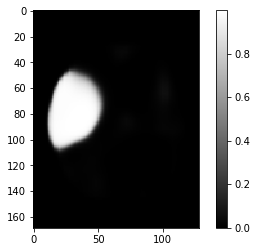

[iter: 151 ]: Training Loss: 0.04 	 Accuracy: 98.53
[iter: 152 ]: Training Loss: 0.03 	 Accuracy: 98.69
[iter: 153 ]: Training Loss: 0.03 	 Accuracy: 98.97
[iter: 154 ]: Training Loss: 0.02 	 Accuracy: 99.11
[iter: 155 ]: Training Loss: 0.03 	 Accuracy: 98.64
[iter: 156 ]: Training Loss: 0.03 	 Accuracy: 98.67
[iter: 157 ]: Training Loss: 0.03 	 Accuracy: 98.73
[iter: 158 ]: Training Loss: 0.04 	 Accuracy: 98.46
[iter: 159 ]: Training Loss: 0.03 	 Accuracy: 98.58
[iter: 160 ]: Training Loss: 0.03 	 Accuracy: 98.74
								 Testing Accuracy: 97.56
Plotting image of shape:  (169, 129)


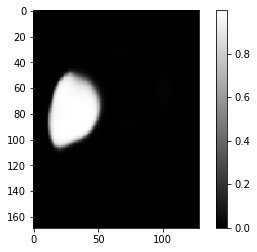

[iter: 161 ]: Training Loss: 0.03 	 Accuracy: 98.93
[iter: 162 ]: Training Loss: 0.02 	 Accuracy: 99.11
[iter: 163 ]: Training Loss: 0.04 	 Accuracy: 98.36
[iter: 164 ]: Training Loss: 0.05 	 Accuracy: 98.34
[iter: 165 ]: Training Loss: 0.07 	 Accuracy: 97.45
[iter: 166 ]: Training Loss: 0.08 	 Accuracy: 96.83
[iter: 167 ]: Training Loss: 0.02 	 Accuracy: 99.12
[iter: 168 ]: Training Loss: 0.04 	 Accuracy: 98.22
[iter: 169 ]: Training Loss: 0.04 	 Accuracy: 98.48
[iter: 170 ]: Training Loss: 0.04 	 Accuracy: 98.53
								 Testing Accuracy: 97.63
Plotting image of shape:  (169, 129)


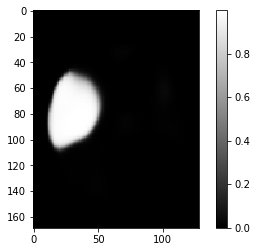

[iter: 171 ]: Training Loss: 0.03 	 Accuracy: 98.72
[iter: 172 ]: Training Loss: 0.04 	 Accuracy: 98.54
[iter: 173 ]: Training Loss: 0.03 	 Accuracy: 98.66
[iter: 174 ]: Training Loss: 0.03 	 Accuracy: 98.81
[iter: 175 ]: Training Loss: 0.03 	 Accuracy: 98.81
[iter: 176 ]: Training Loss: 0.03 	 Accuracy: 98.81
[iter: 177 ]: Training Loss: 0.03 	 Accuracy: 98.82
[iter: 178 ]: Training Loss: 0.02 	 Accuracy: 99.03
[iter: 179 ]: Training Loss: 0.05 	 Accuracy: 98.08
[iter: 180 ]: Training Loss: 0.05 	 Accuracy: 98.18
								 Testing Accuracy: 97.13
Plotting image of shape:  (169, 129)


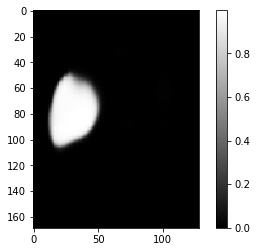

[iter: 181 ]: Training Loss: 0.03 	 Accuracy: 98.79
[iter: 182 ]: Training Loss: 0.03 	 Accuracy: 98.67
[iter: 183 ]: Training Loss: 0.03 	 Accuracy: 98.72
[iter: 184 ]: Training Loss: 0.05 	 Accuracy: 98.10
[iter: 185 ]: Training Loss: 0.06 	 Accuracy: 98.11
[iter: 186 ]: Training Loss: 0.02 	 Accuracy: 99.04
[iter: 187 ]: Training Loss: 0.03 	 Accuracy: 98.83
[iter: 188 ]: Training Loss: 0.03 	 Accuracy: 98.85
[iter: 189 ]: Training Loss: 0.03 	 Accuracy: 98.84
[iter: 190 ]: Training Loss: 0.02 	 Accuracy: 99.03
								 Testing Accuracy: 96.81
Plotting image of shape:  (169, 129)


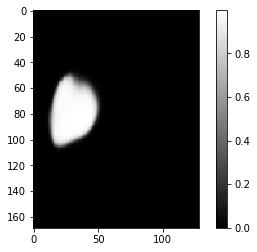

[iter: 191 ]: Training Loss: 0.03 	 Accuracy: 98.67
[iter: 192 ]: Training Loss: 0.03 	 Accuracy: 98.81
[iter: 193 ]: Training Loss: 0.03 	 Accuracy: 98.67
[iter: 194 ]: Training Loss: 0.03 	 Accuracy: 98.73
[iter: 195 ]: Training Loss: 0.03 	 Accuracy: 98.77
[iter: 196 ]: Training Loss: 0.03 	 Accuracy: 98.78
[iter: 197 ]: Training Loss: 0.03 	 Accuracy: 98.67
[iter: 198 ]: Training Loss: 0.03 	 Accuracy: 98.78
[iter: 199 ]: Training Loss: 0.03 	 Accuracy: 98.69
								 Testing Accuracy: 97.72
Plotting image of shape:  (169, 129)


<ipython-input-6-c9983435df5b>:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=figsize) # (figsize=(n_imgs_per_row*0.5, n_rows*0.5)) # size (width, height), in inches.


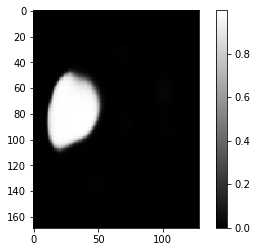

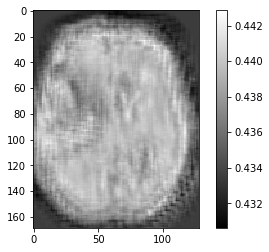

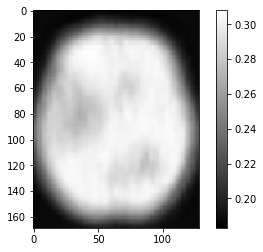

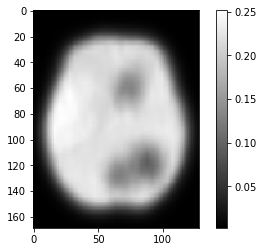

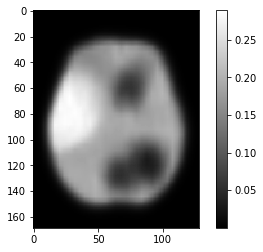

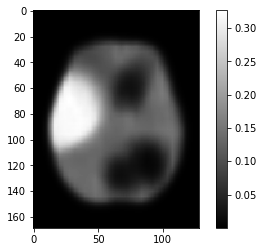

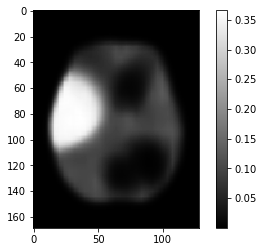

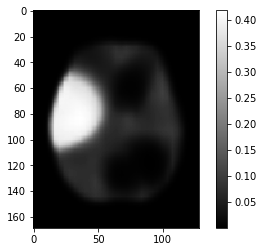

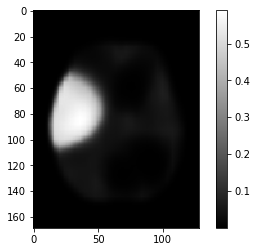

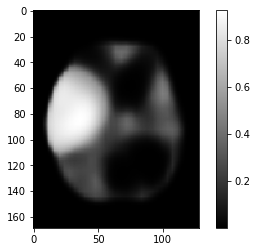

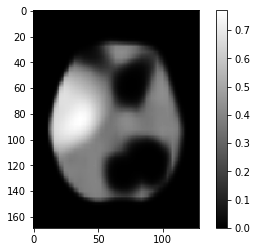

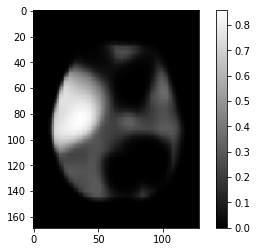

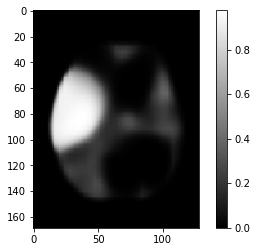

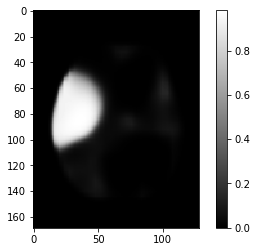

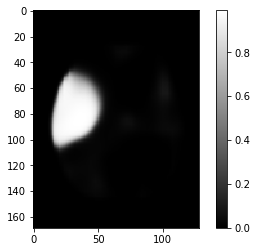

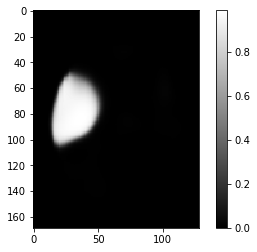

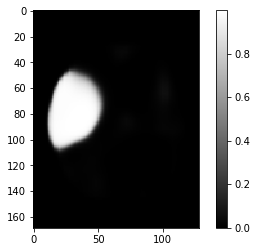

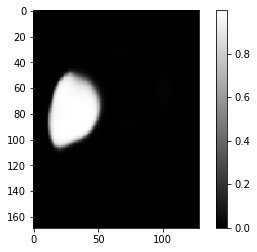

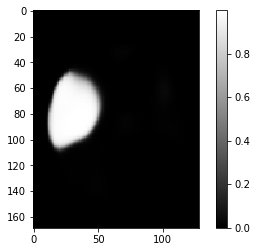

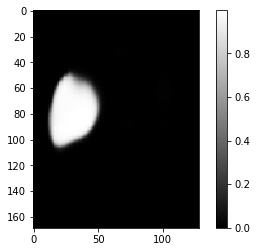

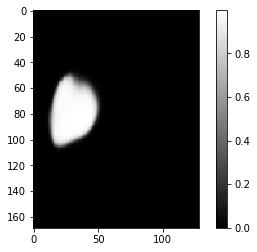

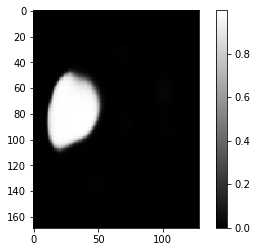

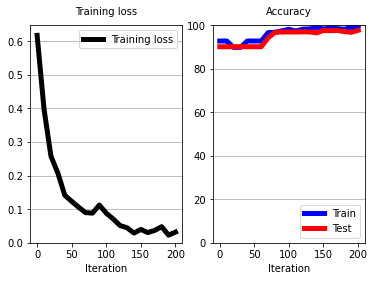

In [60]:
from IPython import display
# Pytorch needs input to conv/pool to be of shape [N, Channels, H, W].
# For grayscale images, there is only 1 image channel. We add this *channels dimension*:
IMAGE_CHANNELS = 1
train_imgs_cnn = train_imgs.reshape([train_imgs.shape[0], IMAGE_CHANNELS, train_imgs.shape[1], train_imgs.shape[2]])
test_imgs_cnn = test_imgs.reshape([test_imgs.shape[0], IMAGE_CHANNELS, test_imgs.shape[1], test_imgs.shape[2]])

######## TODO: Fill the blanks (????) ###########################################################
# Pad 31 voxels along each of the spatial dimensions of the input.
# ... So that the final output is of same size as original input.
# Preferably (roughly) half padding before, half after.
train_imgs_cnn = np.pad(train_imgs_cnn, ((0,0), (0,0), (15,16), (15,16)), mode='edge')
test_imgs_cnn = np.pad(test_imgs_cnn, ((0,0), (0,0), (15,16), (15,16)), mode='edge')
print("train_imgs_cnn.shape=", train_imgs_cnn.shape)
print("train_lbls.shape=", train_lbls.shape)
##################################################################################################

# Create the network
fclenet_seg = FCLeNet_Seg(num_classes=C_classes)

import torch.optim as optim
grad_descent_optimizer = optim.SGD(fclenet_seg.parameters(), lr=0.05, momentum=0.0)

# Start training
rng = np.random.RandomState(seed=SEED)
gradient_descent(fclenet_seg,
                 cross_entropy_segmentation,
                 grad_descent_optimizer,
                 rng,
                 train_imgs_cnn,
                 train_lbls_onehot,
                 test_imgs_cnn,
                 test_lbls_onehot,
                 N_batch_size=2, 
                 total_iters=200,
                 iters_per_test=10,
                 is_tumor_segm=True)

If the whole task was performed correctly, you should see the network learning.  
The probability map for the tumor class will be plotted every few iterations, for the test image.  
If the task was performed correctly, you will see the tumor bright-up after ~200 iterations.

## This notebook:
Copyright 2020, Imperial College London  
Author: Konstantinos Kamnitsas (konstantinos.kamnitsas12@imperial.ac.uk)